In [23]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
batch_size = 32
img_height = 180
img_width = 180

## import and classify images.

In [15]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "data",
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(img_height, img_width),
     batch_size=batch_size
)

Found 25757 files belonging to 53 classes.
Using 20606 files for training.
Using 5151 files for validation.


In [17]:
class_names = train_ds.class_names
print(class_names)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53']


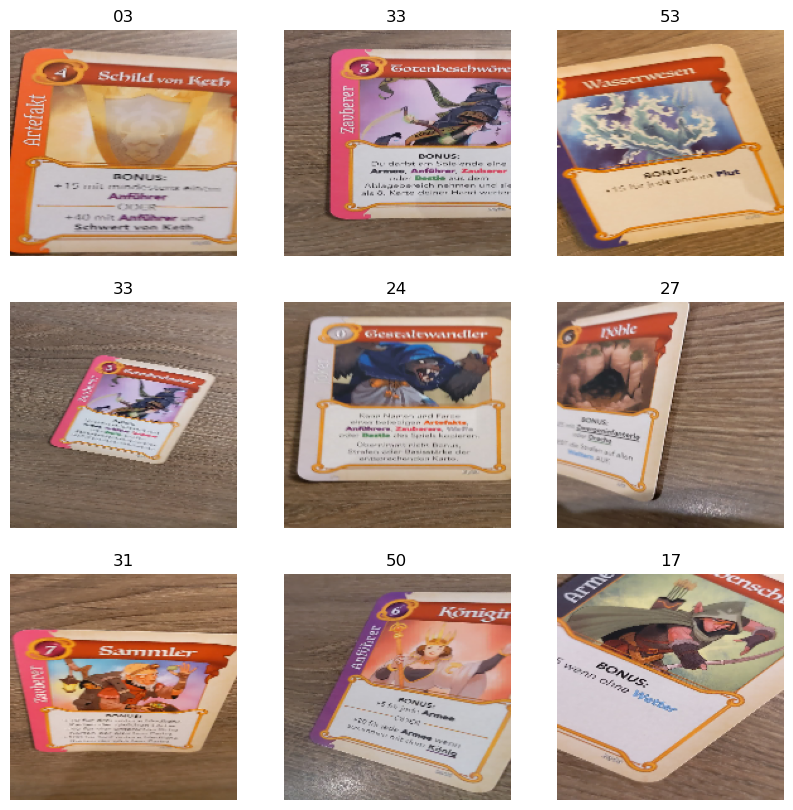

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
normalization_layer = layers.Rescaling(1./255)

In [29]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [31]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

C:\Users\Test\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 53)             │         6,837 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,995,477 (15.24 MB)

 Trainable params: 3,995,477 (15.24 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 91s 138ms/step - accuracy: 0.3409 - loss: 2.6139 - val_accuracy: 0.8965 - val_loss: 0.3380
Epoch 2/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 80s 124ms/step - accuracy: 0.9631 - loss: 0.1251 - val_accuracy: 0.9788 - val_loss: 0.0688
Epoch 3/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 83s 129ms/step - accuracy: 0.9864 - loss: 0.0499 - val_accuracy: 0.9713 - val_loss: 0.1094
Epoch 4/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 83s 128ms/step - accuracy: 0.9870 - loss: 0.0407 - val_accuracy: 0.9777 - val_loss: 0.0628
Epoch 5/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 84s 130ms/step - accuracy: 0.9930 - loss: 0.0263 - val_accuracy: 0.9918 - val_loss: 0.0269
Epoch 6/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 83s 129ms/step - accuracy: 0.9933 - loss: 0.0241 - val_accuracy: 0.9969 - val_loss: 0.0113
Epoch 7/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 87s 135ms/step - accuracy: 0.9999 - loss: 0.0011 - val_accuracy: 0.9140 - val_loss: 0.3965
Epoch 8/10
644/644 ━━━━━━━━━━━━━━━━━━━━ 82s 128ms/step - accuracy: 0.9779 - loss: 0

## data augmentation

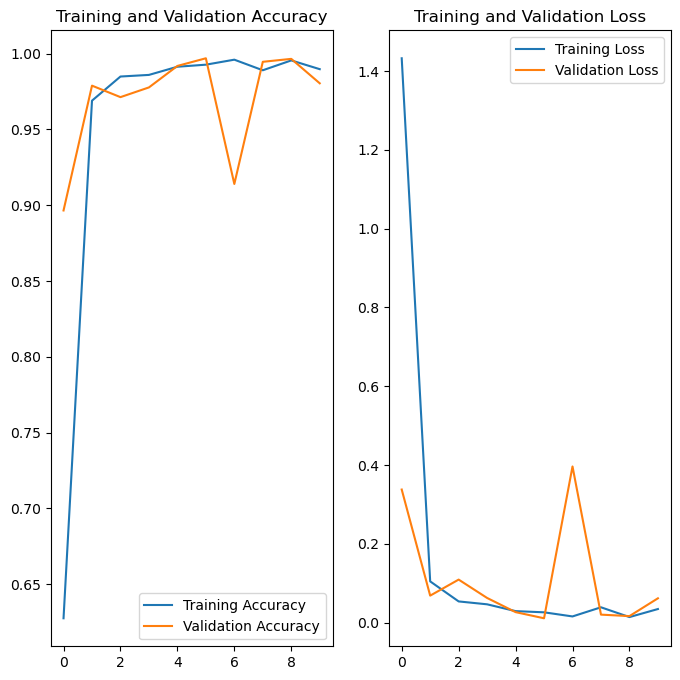

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## validate

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
[[ -8.302062  -44.723686  -52.5386    -31.579952  -22.55044   -24.6108
  -18.612265   -2.3411813   1.4803009 -24.726973    7.541528  -13.505596
  -25.245302  -62.95918   -30.149311   13.108519    9.212653  -34.60976
   17.259933   -2.1148696  16.046316  -38.14918    15.589226  -31.253447
  -38.17609   -22.892206  -31.624397  -13.009172  -25.810953  -28.12601
  -17.24625   -35.33813   -38.070415  -49.858074   -2.7776296  -7.5450025
  -38.154102   -5.9385724 -20.213192  -16.121006  -18.811222   11.036251
    3.4231029   6.983689   12.785784   17.448172    9.481827   -1.4915932
   17.58235   -18.82116    -2.0797398  -5.276811    7.1521745]]


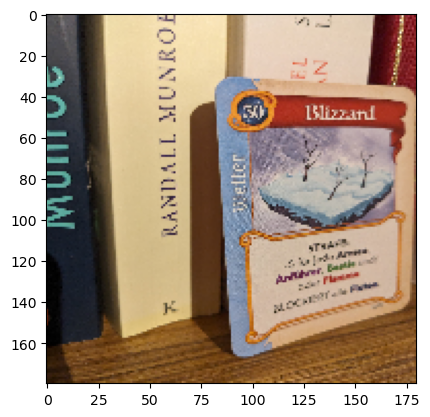

In [47]:
img = keras.utils.load_img("C:/Users/Test/Desktop/WiSe24/nn/project/data2/blizzard/PXL_20241212_185520502.jpg", target_size=(180,180))
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(predictions)